# Task2:LSTM 预测气温数据

### 数据导入

In [1]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as Data
import torch.nn.functional as F

In [2]:
data = pd.read_csv('气温.csv', index_col='DATE', na_values='+9999,9')
data = data['TMP']
data.index = pd.to_datetime(data.index)
start_time = pd.to_datetime('2019-01-01 00:00:00')
end_time = pd.to_datetime('2019-06-30 23:00:00')
data = data[start_time:end_time]
data = data.dropna() # 删除缺失值
data = data.str.split(',', expand=True)[0]
data = data.astype('int')/10
index = pd.date_range(start_time, end_time, freq='H')
index = data.reindex(index)
data = index.interpolate() # 线性插值

/tmp/ipykernel_3386369/3116512502.py:1: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,17,18,20,21,22,23,25,26,27,28,29,31,32,33,34,35,36,37,39,41,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('气温.csv', index_col='DATE', na_values='+9999,9')


### 显示数据

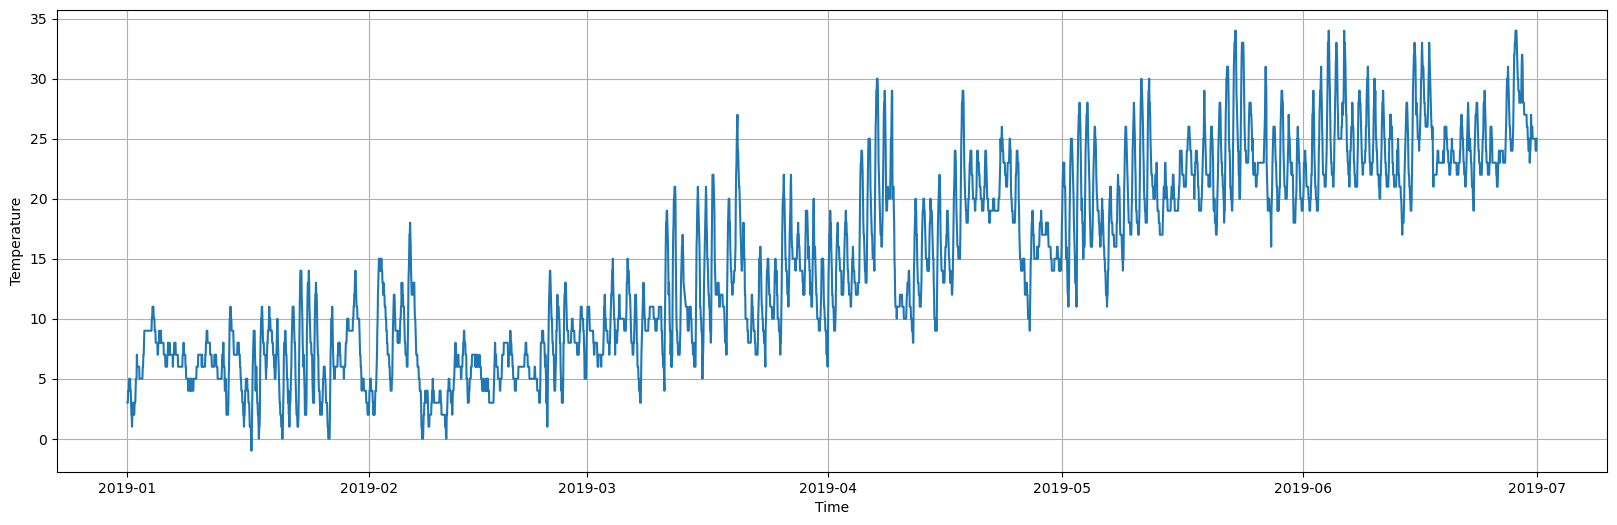

In [5]:
plt.figure(figsize=(20, 6))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

### 参数设置

In [42]:
# 设置超参数
input_size = 1
hidden_size = 128
output_size = 1
epochs = 100
lr = 0.03
batch_size = 20
time_step = 12 # 输入的时间窗口大小

### 划分数据集

In [43]:
# 前 140 天用于训练
train_data = data[0:140*24]
# 剩下的时间用于测试
test_data = data[140*24:]

# 数据归一化
train_data_normalized = (train_data - train_data.min()) / (train_data.max() - train_data.min())
test_data_normalized = (test_data - train_data.min()) / (train_data.max() - train_data.min())

### 滑动窗口采样

In [44]:
train_x, train_y, test_x, test_y = [], [], [], []
# 对训练数据采样
i = 0
while(i + time_step + output_size < len(train_data_normalized)):
    train_x.append(train_data_normalized[i:i+time_step])
    train_y.append(train_data_normalized[i+time_step:i+time_step+output_size])
    i += output_size

# 对测试数据采样
j = 0
while(j + time_step + output_size < len(test_data_normalized)):
    test_x.append(test_data_normalized[j:j+time_step])
    test_y.append(test_data_normalized[j+time_step:j+time_step+output_size])
    j += output_size

### 装入数据

In [45]:
# 转为 tensor
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# 装入 dataloader
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### 构建 LSTM 网络

In [46]:
# 设置默认张量类型为 Float
torch.set_default_tensor_type(torch.FloatTensor)

In [47]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_step):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.time_step = time_step

        # 创建 LSTM 层和 linear 层，LSTM 提取特征，linear 进行预测
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers=1, 
            batch_first=True,
            bidirectional=True)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, x):
        # LSTM 层
        r_out, _ = self.lstm(x)
        # 按照 LETM 模型结构修改 input_seq的形状，作为 linear 层的输入
        r_out = r_out.reshape(-1, self.hidden_size*2)    
        out = self.out(r_out)
        # 将 out恢复成（batch_size, seq_len, output_size）的形状
        out = out.reshape(-1, self.time_step, self.output_size)
        return out[:, -1, :]

### 模型参数初始化

In [48]:
# 实例化神经网络
net = MyLSTM(input_size, hidden_size, output_size, time_step)
# 初始化网络参数
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)
# 设置损失函数
loss = nn.MSELoss()
# 设置优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# GPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
net.to(device)

MyLSTM(
  (lstm): LSTM(1, 128, batch_first=True, bidirectional=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

### 开始训练

In [49]:
train_x.shape

torch.Size([3347, 12])

In [50]:
train_x

tensor([[0.1290, 0.1290, 0.1613,  ..., 0.1613, 0.1613, 0.1290],
        [0.1290, 0.1613, 0.1613,  ..., 0.1613, 0.1290, 0.0968],
        [0.1613, 0.1613, 0.1613,  ..., 0.1290, 0.0968, 0.0968],
        ...,
        [0.8387, 0.8065, 0.7742,  ..., 0.6129, 0.6129, 0.5806],
        [0.8065, 0.7742, 0.6774,  ..., 0.6129, 0.5806, 0.5806],
        [0.7742, 0.6774, 0.6452,  ..., 0.5806, 0.5806, 0.5806]])

In [51]:
def train(net, epochs, train_loader, test_x, test_y):
    train_loss, test_loss = [], []
    for epoch in range(epochs):
        train_l, test_l = [], 0
        for x,y in train_loader:
            # RNN 输入数据的形状为 (seq_len, batch, input_size),于是将 x 转为三维
            x = torch.unsqueeze(x, dim=2)
            # GPU
            x, y = x.to(device), y.to(device)
            # 预测
            y_predict = net(x)
            # 计算 loss
            l = loss(y_predict, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l.append(l.item())
        # 修改测试集的维度
        test_x_temp = torch.unsqueeze(test_x, dim=2)
        # GPU
        test_x_temp = test_x_temp.to(device) 
        test_y_temp = test_y.to(device)
        # 测试集的预测
        test_predict = net(test_x_temp)
        # 计算测试集的 loss
        test_l = loss(test_predict, test_y_temp)
        # 打印输出
        print('epoch %d, train_loss %.5f, test_loss %.5f' % (epoch+1, np.array(train_l).mean(), test_l.item()))

        train_loss.append(np.array(train_l).mean())
        test_loss.append(test_l.item())
    return train_loss, test_loss

In [52]:
train_loss, test_loss = train(net, epochs, train_loader, test_x, test_y)

epoch 1, train_loss 0.05317, test_loss 0.17378
epoch 2, train_loss 0.04382, test_loss 0.17496
epoch 3, train_loss 0.04349, test_loss 0.16738
epoch 4, train_loss 0.04286, test_loss 0.16924
epoch 5, train_loss 0.04170, test_loss 0.16676
epoch 6, train_loss 0.04059, test_loss 0.14814
epoch 7, train_loss 0.03859, test_loss 0.13711
epoch 8, train_loss 0.03601, test_loss 0.13215
epoch 9, train_loss 0.03239, test_loss 0.10927
epoch 10, train_loss 0.02748, test_loss 0.09951
epoch 11, train_loss 0.02197, test_loss 0.06286
epoch 12, train_loss 0.01609, test_loss 0.04728
epoch 13, train_loss 0.01081, test_loss 0.02896
epoch 14, train_loss 0.00685, test_loss 0.01399
epoch 15, train_loss 0.00454, test_loss 0.00801
epoch 16, train_loss 0.00348, test_loss 0.00463
epoch 17, train_loss 0.00304, test_loss 0.00380
epoch 18, train_loss 0.00290, test_loss 0.00340
epoch 19, train_loss 0.00283, test_loss 0.00355
epoch 20, train_loss 0.00280, test_loss 0.00343
epoch 21, train_loss 0.00279, test_loss 0.00314
e

### 绘制 loss 曲线

In [53]:
def plot_loss(train_loss, test_loss):
    plt.plot(range(epochs), train_loss, label='train_loss')
    plt.plot(range(epochs), test_loss, label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

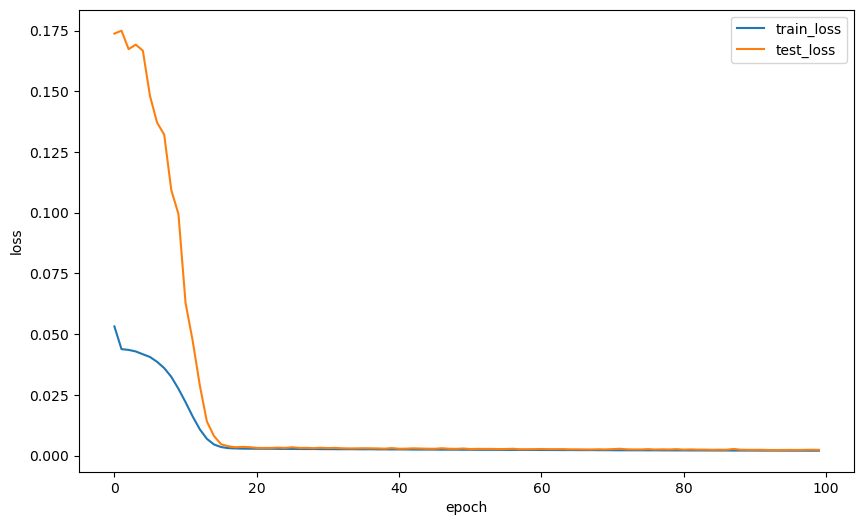

In [54]:
plot_loss(train_loss, test_loss)

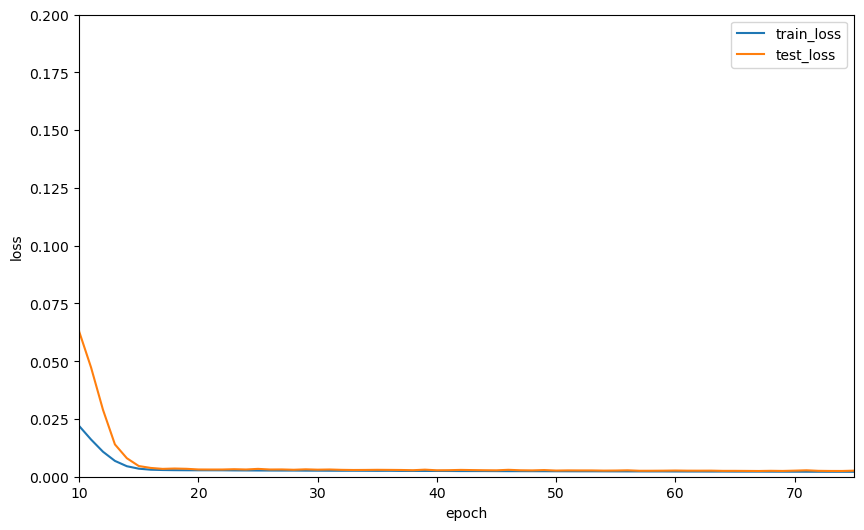

In [55]:
# 绘制局部 loss
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.xlim(10, 75)
plt.ylim(0, 0.2)
plt.show()

### 预测并与真实值对比

In [56]:
test_x_temp = torch.unsqueeze(test_x, dim=2)
test_x_temp = test_x_temp.to(device)
predict = net(test_x_temp)
# 逆归一化
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
test_y = np.array(test_y) * (train_data.max() - train_data.min()) + train_data.min()
# 将数据从[[output_size]]转为[x1, x2, x3, ...]
predict_result = []
test_y_result = []
for item in predict:
    predict_result += item.tolist()
for item in test_y:
    test_y_result += item.tolist()

### 预测并与真实值对比

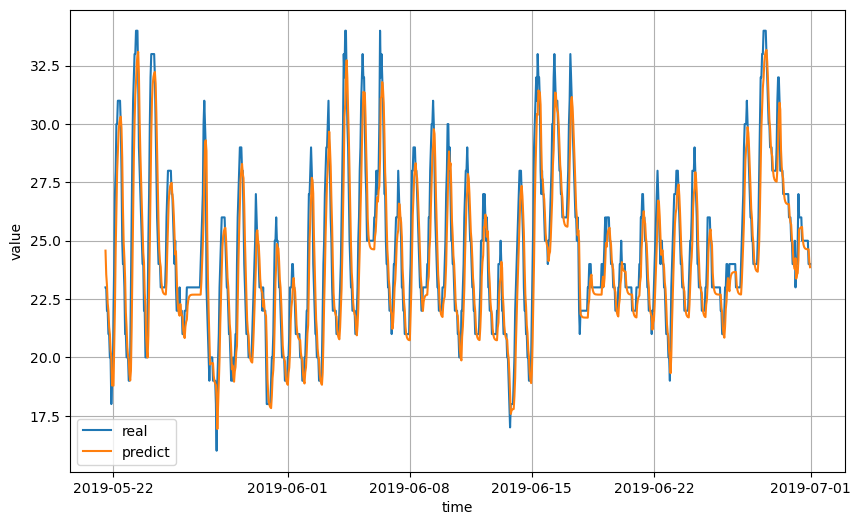

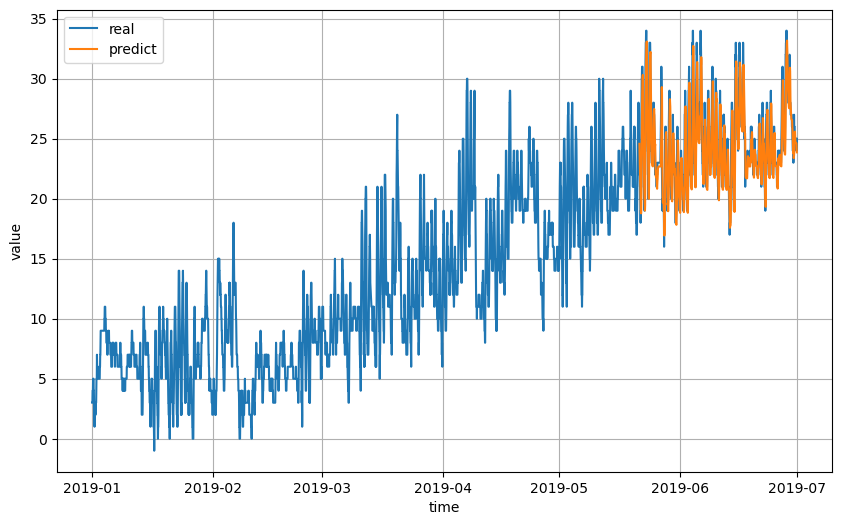

In [57]:
# 指定figure的宽和高
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
# 画出实际和预测的对比图
plt.plot(data.index[len(data)-len(test_y_result):], test_y_result, label='real')
plt.plot(data.index[len(data)-len(predict_result):], predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()
# 与整体数据进行比较
plt.plot(data.index, data, label='real')
plt.plot(data.index[len(data)-len(predict_result):], predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()

### 计算MSE

In [58]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y_result, predict_result)
print('MSE:', mse)

MSE: 2.2486356758131127


## 下面更改模型的窗口大小，使用过去 24 小时的数据进行预测

### 参数设置

In [59]:
# 设置超参数
input_size = 1
hidden_size = 128
output_size = 1
epochs = 100
lr = 0.03
batch_size = 20
time_step = 24 # 输入的时间窗口大小

### 滑动窗口采样

In [60]:
train_x, train_y, test_x, test_y = [], [], [], []
# 对训练数据采样
i = 0
while(i + time_step + output_size < len(train_data_normalized)):
    train_x.append(train_data_normalized[i:i+time_step])
    train_y.append(train_data_normalized[i+time_step:i+time_step+output_size])
    i += output_size

# 对测试数据采样
j = 0
while(j + time_step + output_size < len(test_data_normalized)):
    test_x.append(test_data_normalized[j:j+time_step])
    test_y.append(test_data_normalized[j+time_step:j+time_step+output_size])
    j += output_size

### 装入数据

In [61]:
# 转为 tensor
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# 装入 dataloader
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### 模型参数初始化

In [62]:
# 实例化神经网络
net = MyLSTM(input_size, hidden_size, output_size, time_step)
# 初始化网络参数
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)
# 设置损失函数
loss = nn.MSELoss()
# 设置优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# GPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
net.to(device)

MyLSTM(
  (lstm): LSTM(1, 128, batch_first=True, bidirectional=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

### 开始训练

In [63]:
train_loss, test_loss = train(net, epochs, train_loader, test_x, test_y)

epoch 1, train_loss 0.05293, test_loss 0.17124
epoch 2, train_loss 0.04369, test_loss 0.16975
epoch 3, train_loss 0.04322, test_loss 0.16261
epoch 4, train_loss 0.04259, test_loss 0.16869
epoch 5, train_loss 0.04155, test_loss 0.16563
epoch 6, train_loss 0.04023, test_loss 0.16450
epoch 7, train_loss 0.03841, test_loss 0.13883
epoch 8, train_loss 0.03577, test_loss 0.13350
epoch 9, train_loss 0.03218, test_loss 0.11947
epoch 10, train_loss 0.02761, test_loss 0.10412
epoch 11, train_loss 0.02221, test_loss 0.07251
epoch 12, train_loss 0.01645, test_loss 0.04815
epoch 13, train_loss 0.01111, test_loss 0.02882
epoch 14, train_loss 0.00710, test_loss 0.01531
epoch 15, train_loss 0.00467, test_loss 0.00826
epoch 16, train_loss 0.00352, test_loss 0.00563
epoch 17, train_loss 0.00305, test_loss 0.00410
epoch 18, train_loss 0.00289, test_loss 0.00350
epoch 19, train_loss 0.00283, test_loss 0.00331
epoch 20, train_loss 0.00280, test_loss 0.00343
epoch 21, train_loss 0.00277, test_loss 0.00312
e

### 绘制 loss 曲线

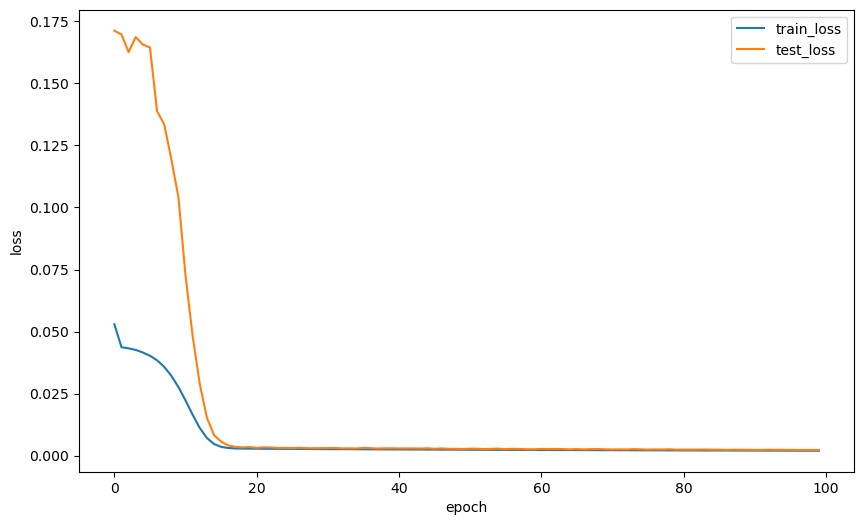

In [64]:
plot_loss(train_loss, test_loss)

### 预测并与真实值对比

In [65]:
test_x_temp = torch.unsqueeze(test_x, dim=2)
test_x_temp = test_x_temp.to(device)
predict = net(test_x_temp)
# 逆归一化
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
test_y = np.array(test_y) * (train_data.max() - train_data.min()) + train_data.min()
# 将数据从[[output_size]]转为[x1, x2, x3, ...]
predict_result = []
test_y_result = []
for item in predict:
    predict_result += item.tolist()
for item in test_y:
    test_y_result += item.tolist()

### 预测并与真实值对比

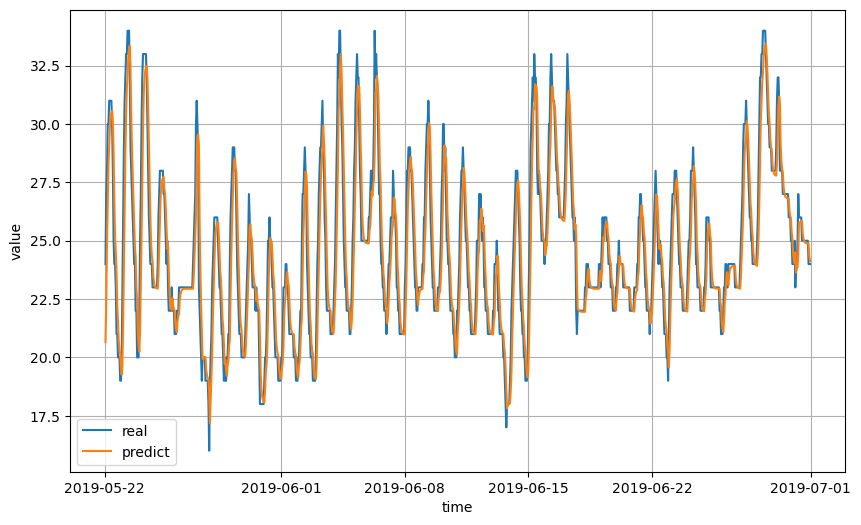

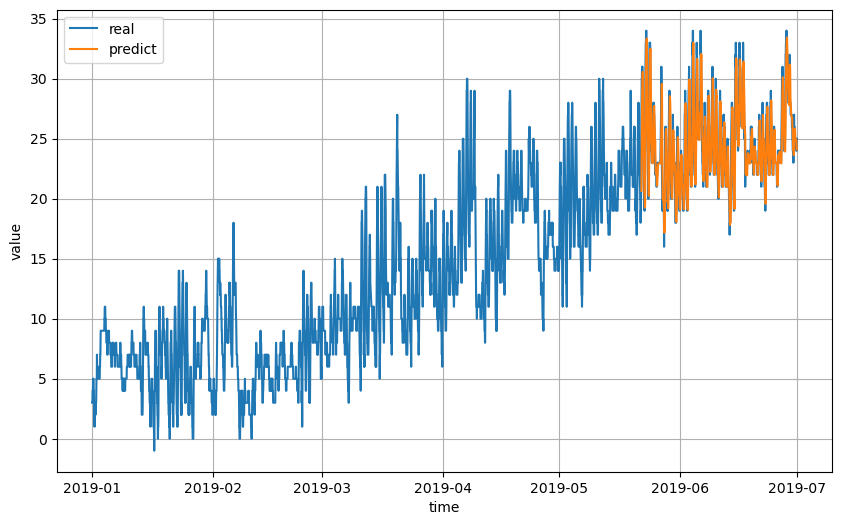

In [66]:
# 指定figure的宽和高
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
# 画出实际和预测的对比图
plt.plot(data.index[len(data)-len(test_y_result):], test_y_result, label='real')
plt.plot(data.index[len(data)-len(predict_result):], predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()
# 与整体数据进行比较
plt.plot(data.index, data, label='real')
plt.plot(data.index[len(data)-len(predict_result):], predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()

### 计算MSE

In [67]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y_result, predict_result)
print('MSE:', mse)

MSE: 2.118673317654714


### 总结：
使用过去 24 小时的数据预测未来 24 小时的气温，模型的 MSE 为 2.11 ，效果也较好。

## 更改网络结构——使用GRU

### 参数设置

In [68]:
# 设置超参数
input_size = 1
hidden_size = 128
output_size = 1
epochs = 100
lr = 0.03
batch_size = 20
time_step = 12 # 输入的时间窗口大小

### 滑动窗口采样

In [69]:
train_x, train_y, test_x, test_y = [], [], [], []
# 对训练数据采样
i = 0
while(i + time_step + output_size < len(train_data_normalized)):
    train_x.append(train_data_normalized[i:i+time_step])
    train_y.append(train_data_normalized[i+time_step:i+time_step+output_size])
    i += output_size

# 对测试数据采样
j = 0
while(j + time_step + output_size < len(test_data_normalized)):
    test_x.append(test_data_normalized[j:j+time_step])
    test_y.append(test_data_normalized[j+time_step:j+time_step+output_size])
    j += output_size

### 装入数据

In [70]:
# 转为 tensor
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# 装入 dataloader
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### 构建 GRU 网络

In [71]:
# 设置默认张量类型为 Float
torch.set_default_tensor_type(torch.FloatTensor)

In [72]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_step):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.time_step = time_step

        # 创建 GRU 层和 linear 层，LSTM 提取特征，linear 进行预测
        self.gru = nn.GRU(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers=1, 
            batch_first=True,
            bidirectional=True)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, x):
        # GRU 层
        r_out, _ = self.gru(x)
        # 按照 LETM 模型结构修改 input_seq的形状，作为 linear 层的输入
        r_out = r_out.reshape(-1, self.hidden_size*2)    
        out = self.out(r_out)
        # 将 out恢复成（batch_size, seq_len, output_size）的形状
        out = out.reshape(-1, self.time_step, self.output_size)
        return out[:, -1, :]

### 模型参数初始化

In [73]:
# 实例化神经网络
net = MyGRU(input_size, hidden_size, output_size, time_step)
# 初始化网络参数
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)
# 设置损失函数
loss = nn.MSELoss()
# 设置优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# GPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
net.to(device)

MyGRU(
  (gru): GRU(1, 128, batch_first=True, bidirectional=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

### 开始训练

In [74]:
train_loss, test_loss = train(net, epochs, train_loader, test_x, test_y)

epoch 1, train_loss 0.05114, test_loss 0.16204
epoch 2, train_loss 0.04158, test_loss 0.15247
epoch 3, train_loss 0.03786, test_loss 0.14755
epoch 4, train_loss 0.03167, test_loss 0.09651
epoch 5, train_loss 0.02225, test_loss 0.06108
epoch 6, train_loss 0.01250, test_loss 0.02701
epoch 7, train_loss 0.00600, test_loss 0.01094
epoch 8, train_loss 0.00332, test_loss 0.00389
epoch 9, train_loss 0.00260, test_loss 0.00342
epoch 10, train_loss 0.00246, test_loss 0.00279
epoch 11, train_loss 0.00242, test_loss 0.00271
epoch 12, train_loss 0.00240, test_loss 0.00272
epoch 13, train_loss 0.00238, test_loss 0.00284
epoch 14, train_loss 0.00237, test_loss 0.00269
epoch 15, train_loss 0.00236, test_loss 0.00281
epoch 16, train_loss 0.00234, test_loss 0.00270
epoch 17, train_loss 0.00234, test_loss 0.00288
epoch 18, train_loss 0.00233, test_loss 0.00264
epoch 19, train_loss 0.00232, test_loss 0.00261
epoch 20, train_loss 0.00230, test_loss 0.00264
epoch 21, train_loss 0.00229, test_loss 0.00262
e

### 绘制 loss 曲线

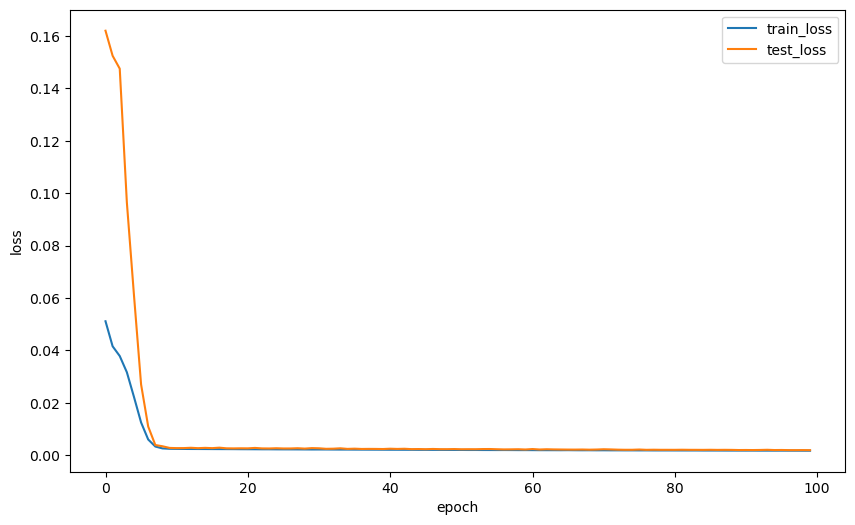

In [75]:
plot_loss(train_loss, test_loss)

### 预测并与真实值对比

In [76]:
test_x_temp = torch.unsqueeze(test_x, dim=2)
test_x_temp = test_x_temp.to(device)
predict = net(test_x_temp)
# 逆归一化
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
test_y = np.array(test_y) * (train_data.max() - train_data.min()) + train_data.min()
# 将数据从[[output_size]]转为[x1, x2, x3, ...]
predict_result = []
test_y_result = []
for item in predict:
    predict_result += item.tolist()
for item in test_y:
    test_y_result += item.tolist()

### 预测并与真实值对比

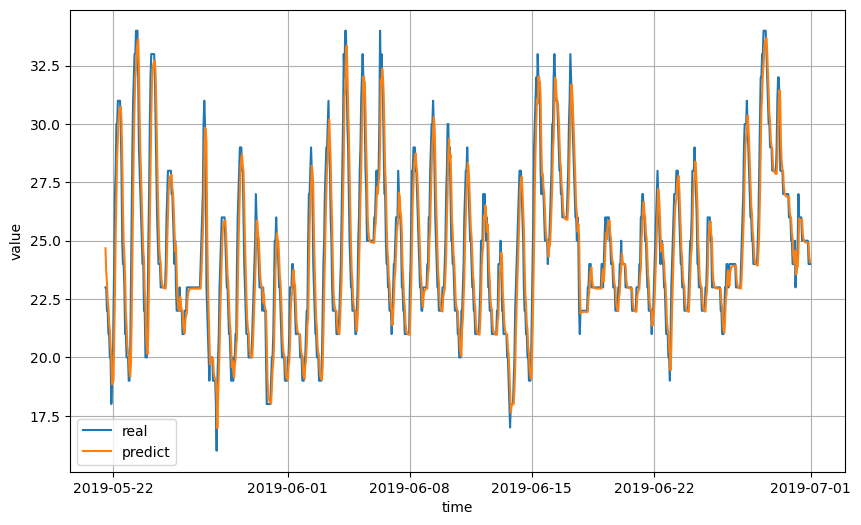

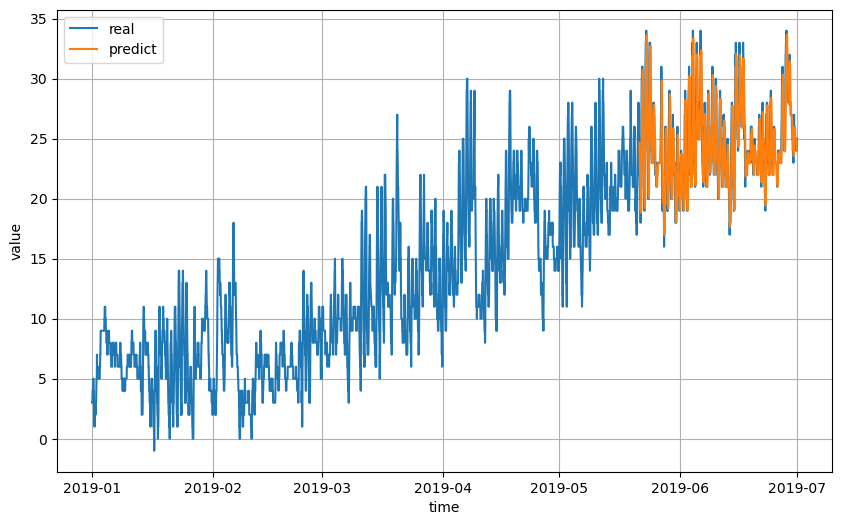

In [77]:
# 指定figure的宽和高
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
# 画出实际和预测的对比图
plt.plot(data.index[len(data)-len(test_y_result):], test_y_result, label='real')
plt.plot(data.index[len(data)-len(predict_result):], predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()
# 与整体数据进行比较
plt.plot(data.index, data, label='real')
plt.plot(data.index[len(data)-len(predict_result):], predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()

### 计算MSE

In [78]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y_result, predict_result)
print('MSE:', mse)

MSE: 1.8527309531301117


### 总结：
1. 与 PPT 中的 LSTM 模型对比，使用 GRU 模型的 MSE 为 1.85 ，效果比 LSTM 更好。
2. 与之前的实验相比：CNN 模型的 MSE 为 3.74，因此 GRU 的效果相比之下更好。
3. 此外，GRU 的训练时间与 LSTM 和 CNN 相比是最短的，因为参数量较小。


各个模型的优缺点：CNN 模型适合处理二维以上的数据，不具备记忆功能；LSTM 和 GRU 都具有记忆特点，并且都解决了 RNN 面临的的长程依赖问题，因此 LSTM 和 GRU 适用于序列数据，例如时间序列和文本数据；最后，GRU 与 LSTM 相比，模型更简单、参数更少，因此运行更快，但在更长的序列中，GRU 的性能不一定比得过 LSTM